# Further analysis
Here we analyse some of the subgroups of offensive language further as we want to see whether we can separate them. We focus on labels and their 50 nearest words. We use mostly Word2Vec and GloVe for this analysis.

In [1]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
TOP_N = 50

KEYS = { \
   
    "offensive": set(),
    "threat": set(), 
    "hostile": set(), 
    "discredit": set(), 
    "benevolent": set()
}
FIXED_KEYS = list(KEYS.keys())

In [3]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'threat': {'threat'},
 'hostile': {'hostil', 'hostile'},
 'discredit': {'discredit'},
 'benevolent': {'benevol', 'benevolent'}}

In [4]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [5]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [6]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [7]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [9]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [11]:
def plot_similar_words3d(title, labels, embedding_clusters, word_clusters, filename=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        z = embeddings[:, 2]
        ax.scatter(x, y,z, c=color, alpha=0.7, label=label)
        #for i, word in enumerate(words):              
            #plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
            #             textcoords='offset points', ha='right', va='bottom', size=8)
        #    plt.text(x,y,z, word, alpha=0.5,
        #                 textcoords='offset points', ha='right', va='bottom', size=8)
        #    ax.text(x,y,z, word, alpha=1.0,
        #        textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
def plotMDS3D(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_3d = MDS(n_components=3, max_iter=3500, random_state=32)
    model_en_3d = model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_3d = np.array(model_en_3d).reshape(n, m, 3)
    plot_similar_words3d(title, FIXED_KEYS, embeddings_en_3d, word_clusters, filename)

In [13]:
model_gn = gensim.downloader.load('word2vec-google-news-300')

In [14]:
word_clusters_a, embedding_clusters = getSimilarWords(model_gn)

{'offens', 'offensive'} -- offensive
{'offens', 'offensive'} -- offensively
{'offens', 'offensive'} -- offense
{'offens', 'offensive'} -- offensively
{'offens', 'offensive'} -- offensive line
{'offens', 'offensive'} -- offensive firepower
{'offens', 'offensive'} -- offensive linemen
{'offens', 'offensive'} -- offense sputtered
{'threat'} -- threats
{'threat'} -- threat posed
{'threat'} -- threat
{'threat'} -- existential threat
{'threat'} -- pose threat
{'threat'} -- graver threat
{'threat'} -- gravest threat
{'threat'} -- threats
{'threat'} -- threatened
{'threat'} -- cyberthreat
{'threat'} -- threaten
{'threat'} -- threatening
{'threat'} -- gravest threats
{'threat'} -- threatens
{'threat'} -- veiled threat
{'threat'} -- cyberthreats
{'threat'} -- asymmetric threats
{'threat'} -- threating
{'hostil', 'hostile'} -- hostile
{'hostil', 'hostile'} -- hostility
{'hostil', 'hostile'} -- nonhostile
{'hostil', 'hostile'} -- nonhostile causes
{'hostil', 'hostile'} -- hostile takeover
{'hostil

In [16]:
displayDF(word_clusters_a)

,offensive,threat,hostile,discredit,benevolent
0,defensive,danger,unfriendly,malign,beneficent
1,coach_Bob_Palcic,imminent_danger,antagonistic,besmirch,magnanimous
2,guard_RJ_Mattes,menace,nipple_pinching,embarrass,beneficence
3,coach_Jimmy_Heggins,challenge,warlike,delegitimize,altruistic
4,promoted_Pete_Metzelaars,dangers,unwelcoming,demonize,saintly
5,Dave_Borbely,hazard,mistaken_celebratory_gunfire,smear,malevolent
6,coach_George_Yarno,nightmare_scenario,confrontational,marginalize,generous
7,coach_Dave_Magazu,possibility,inhospitable,vilify,munificent
8,coach_Greg_Studrawa,peril,belligerent,denigrate,tyrannical
9,coach_Dan_Roushar,concern,neocolonialist_enemies,belittle,bighearted


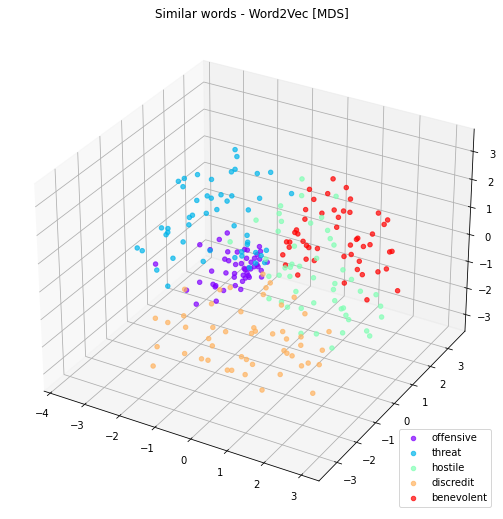

In [17]:

plotMDS3D("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS_3d.png")

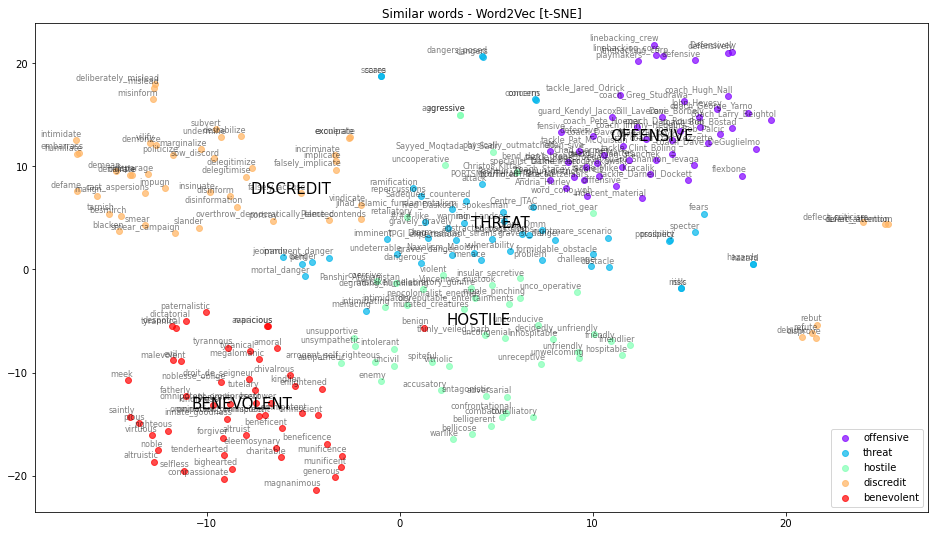

In [18]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters_a, embedding_clusters, "Further analysis2 Word2Vec - t-SNE.png")

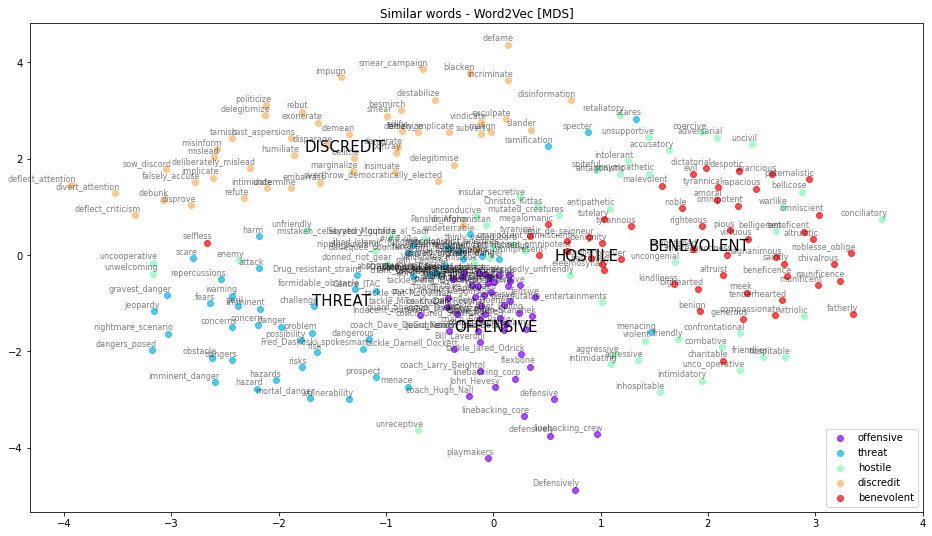

In [19]:
plotMDS("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "Further analysis2 Word2Vec - MDS.png")

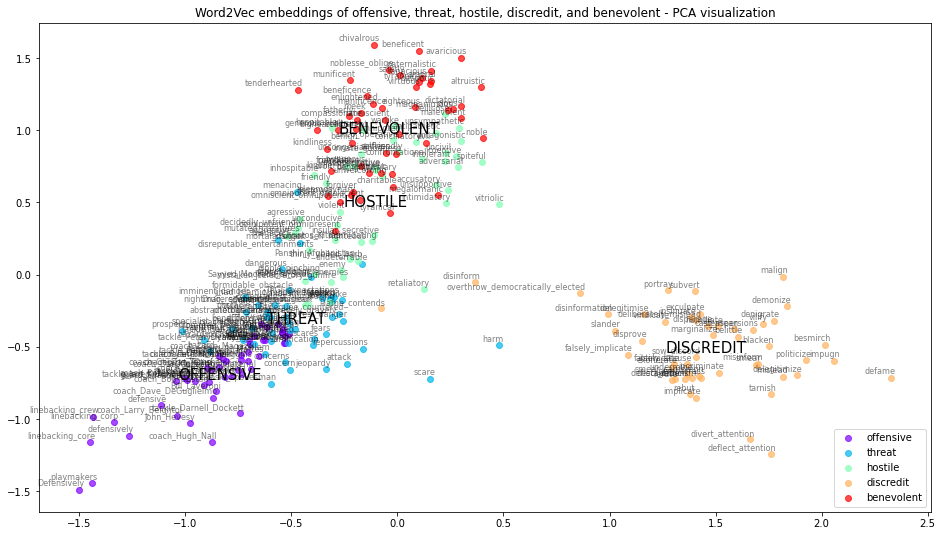

In [20]:
plotPCA("Word2Vec embeddings of offensive, threat, hostile, discredit, and benevolent - PCA visualization", word_clusters_a, embedding_clusters, "Further analysis2 Word2Vec - PCA.png")

# glove

In [29]:
# stran dala: douchebag, feminazi

In [30]:
TOP_N = 50
KEYS = { \
   
    "threat": set(),
    "hostile": set(), 
    "offensive": set(), 
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'threat': {'threat'},
 'hostile': {'hostil', 'hostile'},
 'offensive': {'offens', 'offensive'}}

In [31]:
model_gn = gensim.downloader.load('glove-wiki-gigaword-300')

In [32]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'threat'} -- threats
{'threat'} -- threatening
{'threat'} -- threatened
{'threat'} -- threaten
{'threat'} -- threatens
{'hostil', 'hostile'} -- hostility
{'offens', 'offensive'} -- offense
{'offens', 'offensive'} -- offensives
{'offens', 'offensive'} -- offensively


In [33]:
displayDF(word_clusters)

,threat,hostile,offensive
0,danger,unfriendly,defensive
1,posed,takeover,lineman
2,pose,belligerent,linemen
3,possibility,antagonistic,coordinator
4,warned,enemy,attack
5,warning,takeovers,quarterback
6,poses,threats,blitz
7,imminent,aggressive,forces
8,dangers,fend,fighting
9,possible,enemies,tackle


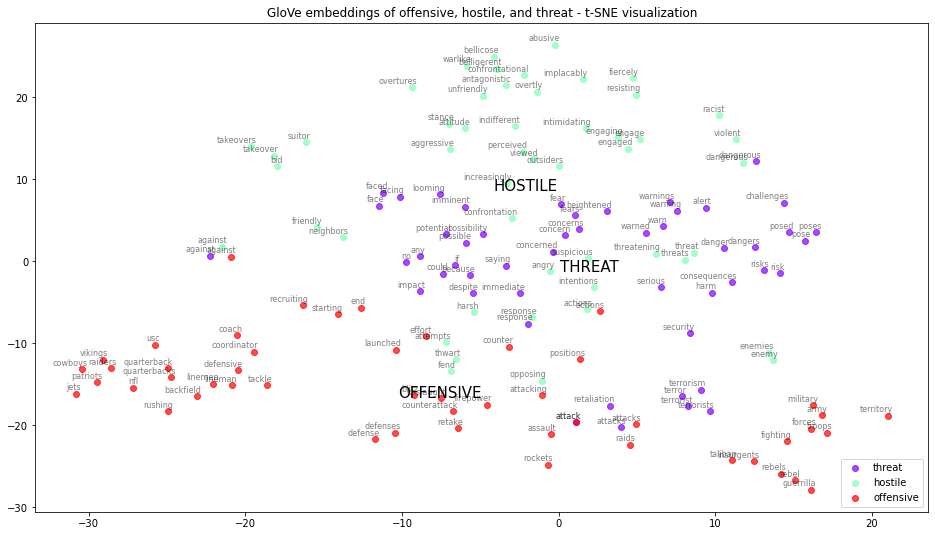

In [34]:
plotTSNE("GloVe embeddings of offensive, hostile, and threat - t-SNE visualization", word_clusters, embedding_clusters, "Further analysis3 - Glove - t-SNE.png")

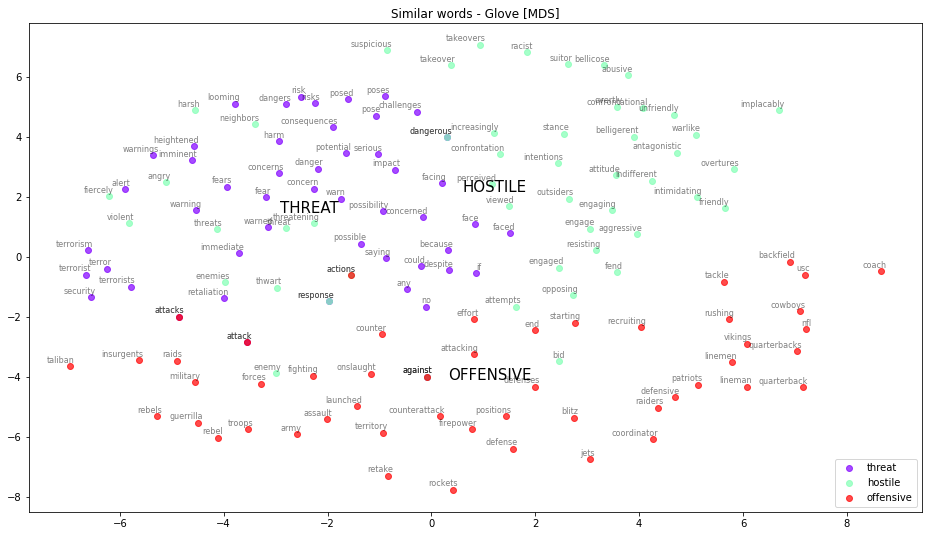

In [35]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "Further analysis3 - Glove - MDS.png")

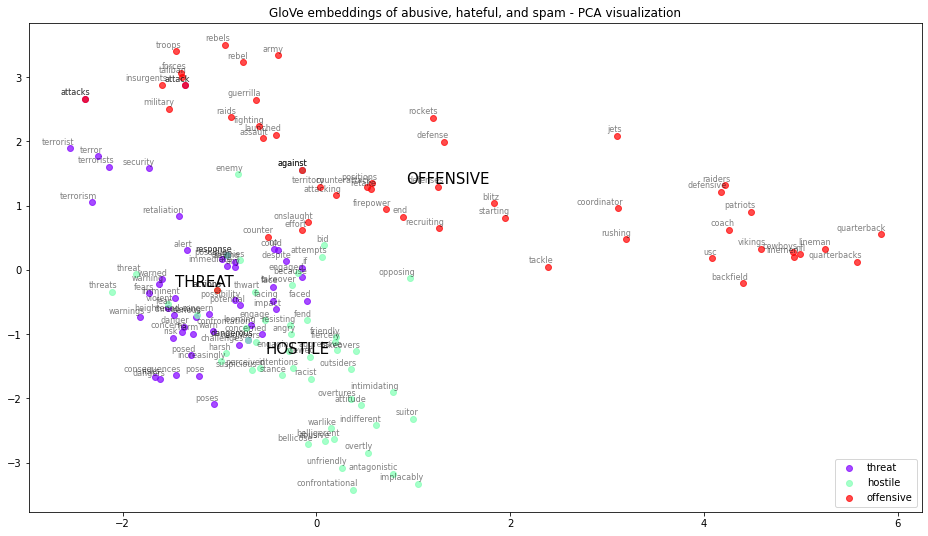

In [36]:
plotPCA("GloVe embeddings of abusive, hateful, and spam - PCA visualization", word_clusters, embedding_clusters, "Further analysis3 - Glove - PCA.png")